# Lab 1: Experiment Tracking
## Exercise 5: Add Confusion Matrix plot

A confusion matrix is a great way to get insight into false positives and false negatives for classification problems. See: https://en.wikipedia.org/wiki/Confusion_matrix

Let's display a confusion matrix using scikit-learn (sklearn). ClearML will automatically pick it up and show it under the PLOTS tab in your experiment. Here are some links to get you started:

https://stackoverflow.com/questions/70775762/how-to-make-a-confusion-matrix-with-keras \
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html \
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

Look at the confusion matrix. Which two classes are the most confusing for our neural network?

Run different experiments and compare their confusion matrix in ClearML. Select two experiments, click COMPARE at the bottom and go to the PLOTS tab.

In [1]:
import os
from dotenv import load_dotenv

# %pip install -q scikit-learn


%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml

load_dotenv()

CLEARML_API_ACCESS_KEY=os.getenv("CLEARML_API_ACCESS_KEY")
CLEARML_API_SECRET_KEY=os.getenv("CLEARML_API_SECRET_KEY")

if CLEARML_API_ACCESS_KEY is None:
    raise KeyError("CLEARML_API_ACCESS_KEY")

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml


ClearML Task: created new task id=5417fa7730fe499884a01927a0436e57
ClearML results page: https://app.clear.ml/projects/6a2816f5dd8b4f2ea853ff5aa8dcf64d/experiments/5417fa7730fe499884a01927a0436e57/output/log
Class names: ['bird', 'cat', 'deer', 'dog']
Number of train images: 16000
Number of test images: 4000
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3184 - loss: 1.3329 - val_accuracy: 0.4708 - val_loss: 1.1463
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4640 - loss: 1.1349 - val_accuracy: 0.5278 - val_loss: 1.0575
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5386 - loss: 1.0309 - val_accuracy: 0.5590 - val_loss: 1.0052
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5870 - loss: 0.9529 - val_accuracy: 0.5885 - val_loss: 0.9605
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6280 - loss: 0.8891 - val_accuracy: 0.6183 - val_loss: 0.9036
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/ste

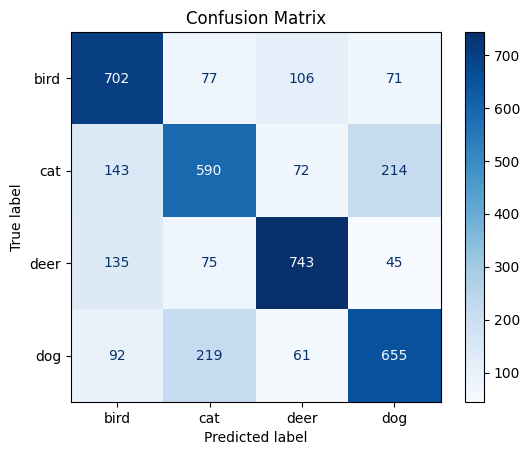

In [7]:
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from clearml import Task, Logger
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

task = Task.init(project_name='vives-ml-workshop', task_name='exercise5', output_uri=True)

# hyperparameters
config = {
    "conv1": 32,
    "conv2": 64,
    "conv3": 64,
    "dense1": 16,
}
task.connect(config)

# ---

# download the dataset
(images, labels), _ = keras.datasets.cifar10.load_data()

# there are 10 classes of images
all_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# choose four classes (feel free to change this!)
class_names = ["bird", "cat", "deer", "dog"]
print("Class names:", class_names)

# only keep images of these classes
class_indexes = [all_classes.index(c) for c in class_names]
to_keep = np.array([l in class_indexes for l in labels])
images = images[to_keep]
labels = labels[to_keep]

# change indexes from 10 to 2 classes
labels = np.array([class_indexes.index(l) for l in labels])

# normalize pixels between 0 and 1
images = images / 255.0

# split into train and test set
split = round(len(images) * 0.8)
train_images = images[:split]
train_labels = labels[:split]
test_images = images[split:]
test_labels = labels[split:]
print("Number of train images:", len(train_images))
print("Number of test images:", len(test_images))

# ---

# create neural network
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3)))

# convolutional layers
model.add(layers.Conv2D(config["conv1"], (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(config["conv2"], (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(config["conv3"], (3, 3), activation="relu"))

# add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(config["dense1"], activation="relu"))
model.add(layers.Dense(4, activation="softmax"))

# ---

# compile and train the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

# ---

# report accuracy to ClearML
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
logger = Logger.current_logger()

for i in range(len(accuracy)):
    logger.report_scalar("training", "accuracy", accuracy[i], iteration=i)
    logger.report_scalar("training", "val_accuracy", val_accuracy[i], iteration=i)

# save model to disk
model.save("model.keras")

# TODO show confusion matrix
test_predict = model.predict(test_images)
test_predict = np.argmax(test_predict, axis=1)

# cm = confusion_matrix(...)
# ConfusionMatrixDisplay(...).plot()

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels,
    test_predict,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)


plt.title("Confusion Matrix")
plt.show()

# close ClearML task
task.close()